In [66]:
# Making the neccessary imports

import numpy as np 
import pandas as pd 
import os

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Define relevant parameters

batch_size = 32
transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5,))
])

In [68]:
# MNIST data cannot be used directly as Lenet5 accepts 32*32 inputs/ So we are reshaping the images here

class Mnist(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        #Each time we get a row of data
        item = self.data.iloc[index]
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transforms is not None:
            image = self.transforms(image)
            
        return image, label

In [69]:
# Loading the datset

dataset = pd.read_csv('train.csv')

In [70]:
mydataset = Mnist(dataset, transforms=transforms)
len(mydataset)

60000

In [71]:
num_train = len(mydataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
# print(split)
train_idx, test_idx = indices[split:], indices[:split]
# print(train_idx)
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

batch_size = 100
train_loader = DataLoader(mydataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(mydataset, batch_size=batch_size, sampler=test_sampler)

In [72]:
import torch.nn as nn

# Defining CNN

# There are two main steps performed here

# 1st is the initialization of layers in init and the other is the forward function

# We first define CNN with the appropriate sizes and similary we define Pooling and sequential layers

# We then proceed to define the fully connected layers. And finally output 10 neurons which are the prediction

class Lenet5(nn.Module):
    def __init__(self):
            super(Lenet5, self).__init__()
            self.conv = nn.Sequential(
                nn.Conv2d(1, 6, 5),   # out = (in - kernal + 2*padding) / stride + 1  (1, 28, 28) -> (6, 24, 24)
                nn.ReLU(),
                nn.AvgPool2d(2, stride=2), # (N, 6, 24, 24) - > (N, 6, 12, 12)
                nn.Conv2d(6, 16, 5), #  (N, 6, 12, 12) -> (N. 6, 8, 8)
                nn.ReLU(),
                nn.AvgPool2d(2, stride=2)# (N, 16, 8, 8) -> (N, 16, 4, 4)
            )

            self.fc = nn.Sequential(
                nn.Linear(256, 120), #(N, 256) - > (N, 120)
                nn.ReLU(),
                nn.Linear(120, 84), #(N, 120) - > (N, 84)
                nn.ReLU(),
                nn.Linear(84, 10)
            )
    def forward(self, x):
        x = self.conv(x)
        #flatten
        x = x.view(x.size(0), -1)
#         print(x.size())
        x = self.fc(x)
        return x

In [73]:
model = Lenet5()

In [74]:
# Hyperparameter setting

# device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
# model = model.to(device)
# optim = optim.Adam(net.parameters(), lr=learning_rate)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [75]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [76]:
num_epochs = 24
best_acc = 0
checkpoint = {}
test_acc_l = []
for epoch in range(num_epochs):
    
    model.train()
    train_loss = 0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        optim.zero_grad()
       
        # Forward pass
        out = model(images)
        loss = criterion(out, labels)
        # Backward and optimization
        loss.backward()
        optim.step()
        train_loss += loss.item()
        
    test_loss = test_acc = correct = 0
    # model evaluation
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            # images, labels = images.to(device), labels.to(device)
            out = model(images)
            test_loss += criterion(out, labels)
            _, pred = torch.max(out, 1)
            correct += pred.eq(labels).sum().item()
    cur_acc = correct/len(test_loader)
    test_acc_l.append(correct/len(test_loader))
    print(f"Epoch: {epoch+1}/{num_epochs}",
          f"Train loss:{train_loss/len(train_loader):.4f}",
          f"Test loss:{test_loss/len(test_loader):.4f}",
          f"Test acc:{correct/len(test_loader):.4f}")
    #Save model state
    if cur_acc > best_acc:
        best_acc = cur_acc
        torch.save(model, 'model.pt')
# 

print(f"Best acc:{best_acc:.4f}")
#torch.save(checkpoint, 'ckp.s')  

Epoch: 1/24 Train loss:0.4344 Test loss:0.1859 Test acc:94.4583
Epoch: 2/24 Train loss:0.1304 Test loss:0.0956 Test acc:97.2000
Epoch: 3/24 Train loss:0.0891 Test loss:0.0846 Test acc:97.4083
Epoch: 4/24 Train loss:0.0707 Test loss:0.0719 Test acc:97.8917
Epoch: 5/24 Train loss:0.0606 Test loss:0.0569 Test acc:98.3500
Epoch: 6/24 Train loss:0.0503 Test loss:0.0526 Test acc:98.4083
Epoch: 7/24 Train loss:0.0440 Test loss:0.0537 Test acc:98.4083
Epoch: 8/24 Train loss:0.0387 Test loss:0.0537 Test acc:98.4667
Epoch: 9/24 Train loss:0.0342 Test loss:0.0482 Test acc:98.4333
Epoch: 10/24 Train loss:0.0311 Test loss:0.0428 Test acc:98.6583
Epoch: 11/24 Train loss:0.0276 Test loss:0.0477 Test acc:98.6083
Epoch: 12/24 Train loss:0.0255 Test loss:0.0408 Test acc:98.8750
Epoch: 13/24 Train loss:0.0228 Test loss:0.0420 Test acc:98.7917
Epoch: 14/24 Train loss:0.0192 Test loss:0.0478 Test acc:98.6583
Epoch: 15/24 Train loss:0.0191 Test loss:0.0412 Test acc:98.9750
Epoch: 16/24 Train loss:0.0167 Tes

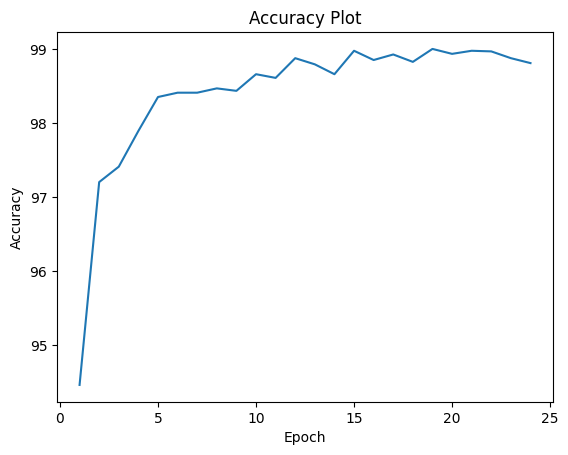

In [77]:
# accuracy

x = np.arange(1, num_epochs+1)
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x, test_acc_l)
plt.show()
